## Classificação multilinguagem

In [1]:
import os
import gc
import pandas as pd
import numpy as np
import glob
import json

import librosa
import librosa.display
import IPython.display as ipd
import noisereduce as nr

import matplotlib.pyplot as plt
%matplotlib inline

/Users/marcospaulo/Projects/multilingual_classification/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0. Carregamos o dataset

Importamos o dataset que geramos anteriormente, com aproximadamente 1 hora de áudio por idioma e balanceado por sexo

In [2]:
%%time
df_audios = pd.read_csv("../data/audios.csv", index_col=0)

CPU times: user 25.3 s, sys: 3.21 s, total: 28.5 s
Wall time: 37.2 s


In [3]:
df_audios.shape

(947, 11)

In [4]:
df_audios.head()

language                id  speaker  book  segment gender  \
0  italian  8828_8610_000510     8828  8610      510      F   
1  italian    659_547_000790      659   547      790      F   
2  italian    643_529_000116      643   529      116      F   
3  italian  8828_8610_000321     8828  8610      321      F   
4  italian    659_547_000279      659   547      279      F   

                                      title  \
0  Novelle per un Anno, vol. 12: Il Viaggio   
1                    Avventure di Pinocchio   
2                           Divina Commedia   
3  Novelle per un Anno, vol. 12: Il Viaggio   
4                    Avventure di Pinocchio   

                                               audio  length     sr  \
0  [0.0, 3.0517578125e-05, 3.0517578125e-05, 6.10...  318560  16000   
1  [0.0, 3.0517578125e-05, 0.0, 3.0517578125e-05,...  186880  16000   
2  [-0.007232666015625, -0.004913330078125, -0.00...  314560  16000   
3  [0.0, 3.0517578125e-05, 0.0, 0.0, 3.0517578125...  229920  16000   
4  [0.0, 0.0, 0.0, -3.0517578125e-05, -9.15527343...  197440  16000   

   duration_s  
0       19.91  
1       11.68  
2       19.66  
3       14.37  
4       12.34

In [5]:
%%time
df_audios["audio"] = df_audios.apply(lambda x : np.array(json.loads(x["audio"])), axis=1)

CPU times: user 25 s, sys: 2.52 s, total: 27.5 s
Wall time: 34 s


In [7]:
df_audios.dtypes

language       object
id             object
speaker         int64
book            int64
segment         int64
gender         object
title          object
audio          object
length          int64
sr              int64
duration_s    float64
dtype: object

In [8]:
type(df_audios.iloc[0]["audio"])

numpy.ndarray

#### Características do sinal e da FFT

In [9]:
sr = 16000

Vamos fazer os tratamentos do sinal para os tamanhos de janela de 50 ms, 250 ms, 500 ms

In [10]:
window_sizes = [0.050, 0.250, 0.500]

In [11]:
window_lengths = [int(sr * window_size) for window_size in window_sizes]
window_lengths

[800, 4000, 8000]

In [12]:
hop_lengths = [int(window_length / 2) for window_length in window_lengths] # sobreposição de 50%
hop_lengths

[400, 2000, 4000]

In [356]:
n_ffts = window_lengths
n_ffts

[800, 4000, 8000]

#### Visualização de um áudio em cada idioma

In [14]:
df_audios["language"].unique()

array(['italian', 'polish', 'portuguese', 'spanish'], dtype=object)

In [15]:
# Italiano
x_ita = df_audios[df_audios["language"] == "italian"].iloc[0]["audio"]
ipd.Audio(x_ita, rate=sr)

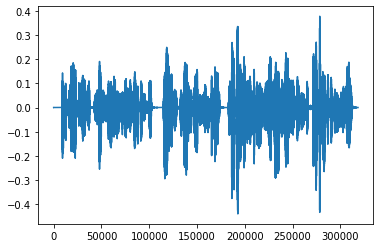

In [16]:
plt.plot(x_ita)

In [17]:
# Polonês
x_pol = df_audios[df_audios["language"] == "polish"].iloc[0]["audio"]
ipd.Audio(x_pol, rate=sr)

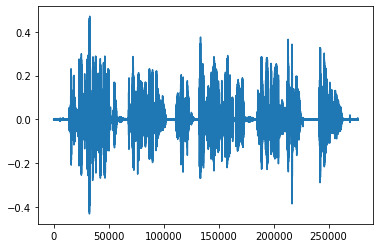

In [18]:
plt.plot(x_pol)

In [19]:
# Português
x_por = df_audios[df_audios["language"] == "portuguese"].iloc[0]["audio"]
ipd.Audio(x_por, rate=sr)

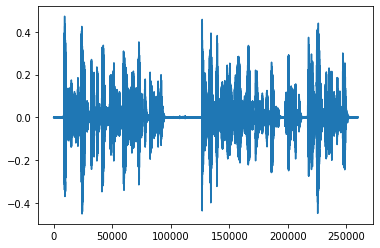

In [20]:
plt.plot(x_por)

In [21]:
# Espanhol
x_esp = df_audios[df_audios["language"] == "spanish"].iloc[0]["audio"]
ipd.Audio(x_esp, rate=sr)

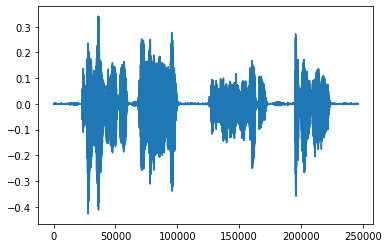

In [22]:
plt.plot(x_esp)

### 1.  Preparação dos áudios

Antes da etapa de feature engineering, precisamos fazer alguns ajustes nos áudios:
* Remoção de ruído
* Remoção de silêncio
    - Cálculo da feature de tempo de silêncio total
* Filtro de pré-ênfase

#### 1.1 Remoção de ruído

Vamos aplicar remoção de ruído para tornar o sinal mais nítido e retirar barulhos de fundo dos áudios. É utilizada uma técnica chamada "spectral gating", que é uma forma de _Noise Gate._ Em [1] está explicado o funcionamento da técnica:

"Noisereduce is a noise reduction algorithm in python that reduces noise in time-domain signals like speech, bioacoustics, and physiological signals. It relies on a method called "spectral gating" which is a form of Noise Gate. It works by computing a spectrogram of a signal (and optionally a noise signal) and estimating a noise threshold (or gate) for each frequency band of that signal/noise. That threshold is used to compute a mask, which gates noise below the frequency-varying threshold.

The most recent version of noisereduce comprises two algorithms:

- Stationary Noise Reduction: Keeps the estimated noise threshold at the same level across the whole signal
- Non-stationary Noise Reduction: Continuously updates the estimated noise threshold over time" (https://pypi.org/project/noisereduce/)

Vamos aplicar ao sinal em português e ver a diferença

In [23]:
ipd.Audio(x_por, rate=sr)

In [24]:
x_por_reduced = nr.reduce_noise(
    y=x_por,
    sr=sr,
    stationary=False,
    prop_decrease=0.8, # Vou tirar 80% do ruído
    n_fft=n_fft,
    win_length=500,
    hop_length=250,
    n_jobs=-1
)

In [25]:
# Português
ipd.Audio(x_por_reduced, rate=sr)

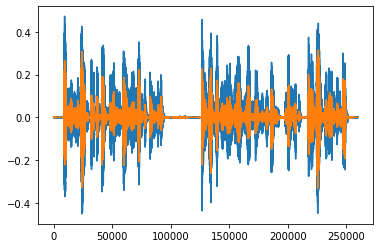

In [26]:
plt.plot(x_por)
plt.plot(x_por_reduced)

Percebemos que o som fica mais limpo após a aplicação da remoção de ruído de fundo.

Função:

In [27]:
def apply_noise_reduction(x, sr, n_fft, win_length, hop_length):
    x_reduced = nr.reduce_noise(
        y=x,
        sr=sr,
        stationary=False, # Non-stationary Noise Reduction: Continuously updates the estimated noise threshold over time
        prop_decrease=0.8, # Vou tirar 80% do ruído
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_jobs=-1
    )
    return x_reduced

In [28]:
apply_noise_reduction(x_por, sr, n_fft, win_length=window_lengths[0], hop_length=hop_lengths[0])

array([-4.88281250e-05,  6.10351563e-06,  5.49316406e-05, ...,
        5.49316363e-05,  3.66210899e-05,  1.22070277e-05])

#### 1.2 Remoção de silêncio

Vamos remover trechos de silêncio do áudio, e computar o total de tempo de silêncio que foi removido. Os trechos de silêncio não trazem uma contribuição significativa para a construção das features de áudio como MFCCs, por exemplo. Portanto, vamos removê-los.

Vamos aplicar ao sinal em português e ver a diferença

##### 1.2.1 Função trim()

Removemos silêncio nos extremos do sinal

In [29]:
ipd.Audio(x_por_reduced, rate=sr)

In [30]:
x_por_trimmed, index = librosa.effects.trim(
    x_por_reduced,
    top_db=50,
    frame_length=500,
    hop_length=250
)

In [31]:
index # non-silent region

array([  8250, 252250])

In [32]:
ipd.Audio(x_por_trimmed, rate=sr)

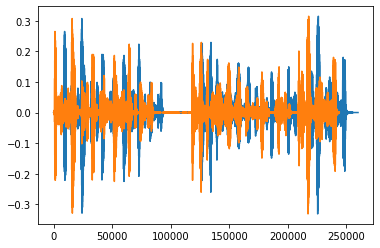

In [33]:
plt.plot(x_por_reduced)
plt.plot(x_por_trimmed)

##### 1.2.2 Função split()

Removemos silêncios dentro do sinal

In [34]:
ipd.Audio(x_por_trimmed, rate=sr)

In [35]:
intervals = librosa.effects.split(
    x_por_trimmed,
    top_db=50,
    frame_length=500,
    hop_length=250
)

In [36]:
intervals

array([[     0,  87000],
       [ 99500,  99750],
       [118250, 185500],
       [189250, 203750],
       [208500, 244000]])

In [37]:
x_por_splitted = []
for interval in intervals:
    x_por_splitted = np.hstack([x_por_splitted, x_por_trimmed[interval[0]:interval[1]]])

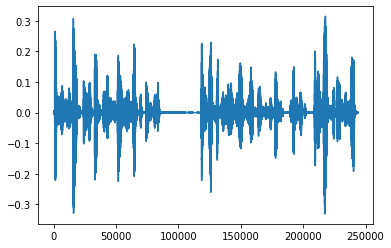

In [38]:
plt.plot(x_por_trimmed)

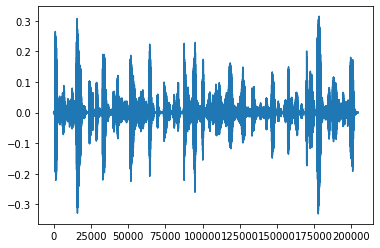

In [39]:
plt.plot(x_por_splitted)

In [40]:
ipd.Audio(x_por_splitted, rate=sr)

#### 1.2.3 Cálculo do tempo total de silêncio

Para calcular esta feature, basta calcular quanto tempo corresponde aos trechos de silêncio removidos do sinal.

In [41]:
index

array([  8250, 252250])

In [42]:
intervals

array([[     0,  87000],
       [ 99500,  99750],
       [118250, 185500],
       [189250, 203750],
       [208500, 244000]])

In [43]:
non_silent_samples = \
    sum([(interval[1] - interval[0]) for interval in intervals]) # splitted

In [44]:
non_silent_samples

204500

In [45]:
silent_samples = len(x_por) - non_silent_samples

In [46]:
silent_samples

55500

In [47]:
total_silent_time = silent_samples / sr

In [48]:
total_silent_time # in seconds

3.46875

Funções:

In [56]:
def apply_trim(x, sr, win_length, hop_length, top_db=50):
    x_trimmed, index = librosa.effects.trim(
        x,
        top_db=top_db,
        frame_length=win_length,
        hop_length=hop_length
    )
    return x_trimmed, index

def apply_split(x, sr, win_length, hop_length, top_db=50):
    intervals = librosa.effects.split(
        x,
        top_db=top_db,
        frame_length=win_length,
        hop_length=hop_length
    )
    
    x_splitted = []
    for interval in intervals:
        x_splitted = np.hstack([x_splitted, x[interval[0]:interval[1]]])
        
    return x_splitted, intervals

def apply_silence_remotion(x, sr, win_length, hop_length, top_db=50):
    x_trimmed, index_non_silent = apply_trim(x, sr, win_length, hop_length, top_db=50)
    x_non_silent, intervals_non_silent = apply_split(x_trimmed, sr, win_length, hop_length, top_db=50)
    return x_non_silent, index_non_silent, intervals_non_silent

def get_total_silence_time(intervals_non_silent):
    non_silent_samples = \
        sum([(interval[1] - interval[0]) for interval in intervals_non_silent]) # splitted
    silent_samples = len(x_por) - non_silent_samples
    total_silent_time = silent_samples / sr
    return total_silent_time # in seconds

In [59]:
apply_trim(x_por_reduced, sr, win_length=window_lengths[0], hop_length=hop_lengths[0], top_db=50)

(array([-5.26733861e-04, -1.60610778e-05,  7.35063548e-05, ...,
         6.71373243e-05, -3.66223727e-05, -3.66223087e-05]),
 array([  8000, 252400]))

In [62]:
apply_split(x_por_trimmed, sr, win_length=window_lengths[0], hop_length=hop_lengths[0], top_db=50)

(array([ 4.70520089e-04,  4.47485428e-05, -8.46050313e-05, ...,
         4.39461602e-04,  4.63876982e-04,  5.79845034e-04]),
 array([[     0,  87200],
        [118000, 185600],
        [189200, 204000],
        [208400, 244000]]))

In [63]:
apply_silence_remotion(x_por_reduced, sr, win_length=window_lengths[0], hop_length=hop_lengths[0], top_db=50)

(array([-5.26733861e-04, -1.60610778e-05,  7.35063548e-05, ...,
         6.71373243e-05, -3.66223727e-05, -3.66223087e-05]),
 array([  8000, 252400]),
 array([[     0,  87200],
        [118400, 186000],
        [189600, 204400],
        [208800, 244400]]))

In [64]:
get_total_silence_time(intervals)

3.46875

#### 1.3 Filtro de pré-ênfase

Aplicamos um filtro de pré-ênfase ao sinal de voz para amplificar as frequências altas e atenuar as frequências baixas. Fazemos isso, pois os sinais de voz apresentam mais energia nas frequências mais baixas em relação às baixas, e gostaríamos de compensar esse efeito.

O filtro de pré-ênfase tem este formato:

$ H(z) = 1 − a z^{−1} $, com $a = 0.97$ ou $a = 0.98$. Vou adotar $a = 0.97$.

In [67]:
ipd.Audio(x_por_splitted, rate=sr)

In [70]:
PRE_EMPHASIS_COEFFICIENT = 0.97
x_transformed = librosa.effects.preemphasis(x_por_splitted, coef=PRE_EMPHASIS_COEFFICIENT)

In [69]:
ipd.Audio(x_transformed, rate=sr)

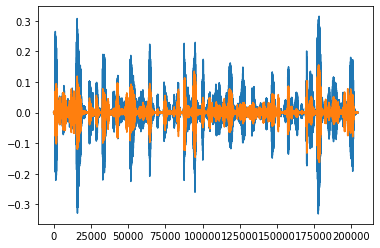

In [68]:
plt.plot(x_por_splitted)
plt.plot(x_transformed)

### 2. Feature engineering

Agora vamos construir algumas features que parecem relevantes para conseguir diferenciar os áudios em relação ao idioma falado:

- Estimação da F0 em cada segmento, delta médio entre segmentos consecutivos (Jitter): frequência (dinâmica da F0 => entonação) (https://librosa.org/doc/main/generated/librosa.pyin.html)
- 13 MFCCs, ∆ and ∆-∆: pitch (percepção da frequência; dinâmica das variações de frequência percebida) (Aula 5 - MFCC_Basics => https://librosa.org/doc/main/generated/librosa.feature.mfcc.html)
- RMS, ∆ and ∆-∆ (log?), Shimmer: energia (variações de energia no sinal de voz => tonicidade / stress) (https://librosa.org/doc/main/generated/librosa.feature.rms.html)
- zero-crossing (total) => intervalos não vozeados, porcentagem do tempo em que zero-cross > 30% (não vozeados), desvio padrão dos tempos dos intervalos não vozeados: ritmo / duração (https://linguistica.fflch.usp.br/sites/linguistica.fflch.usp.br/files/inline-files/The%20Rhythm%20Class%20Hypothesis%20and%20indigenous%20languages.pdf).

Descrições:

- Jitter and shimmer voice-quality measurements measure variations of the fundamental frequency and the amplitude of speaker’s voice, respectively. They have been applied in several speaker-related tasks reporting successful results. For instance, it is reported in [8] that adding jitter and shimmer voice-quality features to the baseline spectral ones improves the performance of a speaker recognition system. By using Praat [33], five different jitter and six different shimmer measurement estimations can be extracted. (https://asmp-eurasipjournals.springeropen.com/track/pdf/10.1186/s13636-018-0140-x.pdf)

<img src="./jitter_shimmer.png" width=250, height=250 />

- Pitch: Pitch is the most important prosodic property of speech. It contains speaker-specific information. The default pitch value and range of a speaker is influenced by the length and mass of the vocal folds in the larynx [35]. The pitch values of different speakers vary in relation to their age and gender. Pitch can be used as an important acoustic cue for tone, lexical stress, and intonation.
(https://librosa.org/doc/main/generated/librosa.pyin.html: calcular f0 de cada segmento e então calcular a média e o desvio padrão)
(https://asmp-eurasipjournals.springeropen.com/track/pdf/10.1186/s13636-018-0140-x.pdf)

- Acoustic intensity: It shows changes in loudness or energy (RMS) of a speech signal. It is used to mark stress and express emotions. Therefore, changes in loudness can be used as a potential speaker discriminant measure.

- Formant frequencies: They are concentrations of acoustic energy around particular frequencies at roughly 1000-Hz intervals. They occur only in voiced speech segments around frequencies that correspond to the speaker-specific resonances of the vocal tract. Therefore, they are suitable measures to help discriminate speakers.

- % vocálicos e desvio padrão

<img src="./proporcao_vocalicos.png" width=250, height=250 />

(https://linguistica.fflch.usp.br/sites/linguistica.fflch.usp.br/files/inline-files/The%20Rhythm%20Class%20Hypothesis%20and%20indigenous%20languages.pdf)

- spectral rollof (https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html), flux, spectral flatness per band
(https://link.springer.com/content/pdf/10.1007/s11042-016-4315-0.pdf)

In [71]:
x_transformed

array([ 1.36681172e-03, -4.11655943e-04, -1.28011118e-04, ...,
        1.31593384e-04,  3.75992274e-05,  1.29884361e-04])

In [72]:
ipd.Audio(x_transformed, rate=sr)

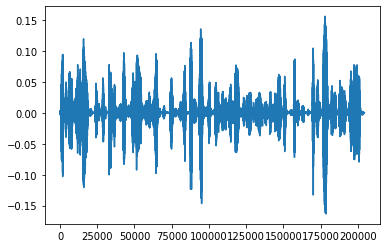

In [73]:
plt.plot(x_transformed)

#### 2.1 Estimação da F0
- F0 em cada segmento
- Jitter (delta médio entre segmentos consecutivos)

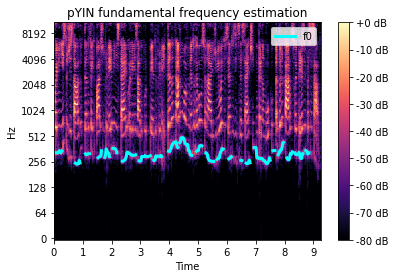

In [372]:
f0, voiced_flag, voiced_probs = librosa.pyin(
    y=x_transformed,
    fmin=librosa.note_to_hz('C2'),
    fmax=librosa.note_to_hz('C7'),
    sr=sr
)
times = librosa.times_like(f0)
D = librosa.amplitude_to_db(np.abs(librosa.stft(x_transformed)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pYIN fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

In [303]:
len(f0)

400

In [339]:
np.sum(df_f0["f0"].notna())

239

In [347]:
df_f0["f0"].diff(-1)

0           NaN
1           NaN
2      1.876709
3      0.000000
4      0.000000
         ...   
395         NaN
396         NaN
397         NaN
398         NaN
399         NaN
Name: f0, Length: 400, dtype: float64

In [348]:
def get_f0_features(df_f0):
    df_f0 = pd.DataFrame(data=f0, columns=["f0"])
    
    f0_mean = np.nanmean(df_f0["f0"])
    f0_std = np.nanstd(df_f0["f0"])
    
    df_f0["diff_f0"] = df_f0["f0"].diff()
    diff_f0_mean = np.nanmean(df_f0["diff_f0"])
    diff_f0_std = np.nanstd(df_f0["diff_f0"])
    df_f0["T"] = 1 / df_f0["f0"]
    df_f0["diff_T"] = df_f0["T"].diff(-1) # passado menos futuro
    df_f0["abs_diff_T"] = df_f0["T"].abs()
    jitter = np.nansum(df_f0["abs_diff_T"]) / (np.sum(df_f0["abs_diff_T"].notna()) - 1)
    
    data = [[f0_mean, f0_std, diff_f0_mean, diff_f0_std, jitter]]
    columns = ["f0_mean", "f0_std", "diff_f0_mean", "diff_f0_std", "jitter"]
    
    df_f0_features = pd.DataFrame(data=data, columns=columns)
    return df_f0_features

In [349]:
get_f0_features(df_f0)

f0_mean     f0_std  diff_f0_mean  diff_f0_std   jitter
0  316.918317  53.215253      1.074399    15.490034  0.00325

Estimativa de f1 e f2 (formantes)

- Intervalos não vozeados
    - Desvio padrão dos tempos dos intervalos não vozeados

In [378]:
df_voiced = pd.DataFrame(data=voiced_flag, columns=["voiced"])
df_voiced.value_counts()

voiced
True      239
False     161
dtype: int64

In [389]:
df_voiced_aux = df_voiced.reset_index()
df_voiced_aux = df_voiced_aux[df_voiced_aux["voiced"] == False]
df_voiced_aux["diff"] = df_voiced_aux["index"].diff()
df_voiced_aux = df_voiced_aux[df_voiced_aux["diff"] > 1]
df_voiced_aux["non_voiced_length"] = df_voiced_aux["diff"] * 512 / 2 # hop_length
# calcular desvio padrão
# calcular a média
df_voiced_aux

index  voiced  diff  non_voiced_length
13      13   False  12.0             3072.0
40      40   False   9.0             2304.0
54      54   False   8.0             2048.0
72      72   False   7.0             1792.0
84      84   False   9.0             2304.0
95      95   False   8.0             2048.0
112    112   False  11.0             2816.0
123    123   False  10.0             2560.0
135    135   False   9.0             2304.0
145    145   False  10.0             2560.0
156    156   False   8.0             2048.0
162    162   False   5.0             1280.0
186    186   False  16.0             4096.0
207    207   False  20.0             5120.0
222    222   False  10.0             2560.0
240    240   False  14.0             3584.0
254    254   False  11.0             2816.0
266    266   False   6.0             1536.0
282    282   False   4.0             1024.0
294    294   False   8.0             2048.0
307    307   False   9.0             2304.0
312    312   False   5.0             1280.0
324    324   False  12.0             3072.0
331    331   False   5.0             1280.0
344    344   False  10.0             2560.0
357    357   False  10.0             2560.0
373    373   False  14.0             3584.0
382    382   False   7.0             1792.0

In [379]:
def get_non_voiced_features(x, df, hop_length=512):
    df_non_voiced = df[df["voiced"] == False]
    
    length_non_voiced = len(df_non_voiced) * hop_length / 2
    percentage_non_voiced = length_non_voiced / len(x)
    
    

voiced
0     False
1     False
2      True
3      True
4      True
..      ...
395   False
396   False
397   False
398   False
399   False

[400 rows x 1 columns]

#### 2.2 MFCCs
- 13 MFCCs
- ∆MFCCs
- ∆-∆MFCCs

In [218]:
n_mfcc = 13

In [219]:
n_mfcc, window_lengths[0], n_ffts[0], hop_lengths[0], len(x_transformed)

(13, 800, 800, 400, 204500)

In [220]:
204500 / 400

511.25

In [269]:
def get_mean_std_from_mfcc(mfcc, order=None):
    df_mfcc = pd.DataFrame(data=mfcc)
    df_mfcc["mean"] = df_mfcc.mean(axis=1)
    df_mfcc["std"] = df_mfcc.std(axis=1)
    
    df_aux = df_mfcc[["mean", "std"]].copy()
    df_aux = df_aux.T
    
    if order == None:
        df_mean = df_aux.loc["mean"].to_frame().T.reset_index(drop=True)
        df_mean.columns = ["mfcc_{}_mean".format(str(col).zfill(2)) for col in df_mean.columns]
        df_std = df_aux.loc["std"].to_frame().T.reset_index(drop=True)
        df_std.columns = ["mfcc_{}_std".format(str(col).zfill(2)) for col in df_std.columns]
    else:
        df_mean = df_aux.loc["mean"].to_frame().T.reset_index(drop=True)
        df_mean.columns = ["mfcc_{}_delta_{}_mean".format(str(col).zfill(2), order) for col in df_mean.columns]
        df_std = df_aux.loc["std"].to_frame().T.reset_index(drop=True)
        df_std.columns = ["mfcc_{}_delta_{}_std".format(str(col).zfill(2), order) for col in df_std.columns]
    
    df_features = pd.concat([df_mean, df_std], axis=1)
    df_features.columns = sorted(df_features.columns)
    return df_features

MFCC

In [270]:
mfcc = librosa.feature.mfcc(
    y=x_transformed,
    sr=sr,
    win_length=window_lengths[0],
    n_fft=n_ffts[0],
    hop_length=hop_lengths[0],
    window='hamming',
    n_mfcc=n_mfcc
)

In [271]:
mfcc_feats = get_mean_std_from_mfcc(mfcc, order=None)

In [272]:
mfcc_feats

mfcc_00_mean  mfcc_00_std  mfcc_01_mean  mfcc_01_std  mfcc_02_mean  \
0   -577.904821     5.447533    -17.630382   -16.964702    -52.110554   

   mfcc_02_std  mfcc_03_mean  mfcc_03_std  mfcc_04_mean  mfcc_04_std  ...  \
0   -11.653869    -21.083392    -14.75577     -1.984224    -12.13082  ...   

   mfcc_08_mean  mfcc_08_std  mfcc_09_mean  mfcc_09_std  mfcc_10_mean  \
0     32.328848    30.269433     22.227756    16.091793     15.240647   

   mfcc_10_std  mfcc_11_mean  mfcc_11_std  mfcc_12_mean  mfcc_12_std  
0    14.268828     14.666899    13.540967     13.891979    14.121749  

[1 rows x 26 columns]

Deltas (order = 1)

In [273]:
mfcc_delta_1 = librosa.feature.delta(mfcc)

In [274]:
mfcc_delta_1_feats = get_mean_std_from_mfcc(mfcc_delta_1, order=1)

In [275]:
mfcc_delta_1_feats

mfcc_00_delta_1_mean  mfcc_00_delta_1_std  mfcc_01_delta_1_mean  \
0             -0.711358             0.070616              0.156459   

   mfcc_01_delta_1_std  mfcc_02_delta_1_mean  mfcc_02_delta_1_std  \
0             0.100217                0.0351            -0.015261   

   mfcc_03_delta_1_mean  mfcc_03_delta_1_std  mfcc_04_delta_1_mean  \
0             -0.010086             0.034316             -0.055997   

   mfcc_04_delta_1_std  ...  mfcc_08_delta_1_mean  mfcc_08_delta_1_std  \
0             0.032049  ...              5.639802             5.825301   

   mfcc_09_delta_1_mean  mfcc_09_delta_1_std  mfcc_10_delta_1_mean  \
0              4.159722             2.770049              2.611888   

   mfcc_10_delta_1_std  mfcc_11_delta_1_mean  mfcc_11_delta_1_std  \
0             2.589931              2.878011             2.465434   

   mfcc_12_delta_1_mean  mfcc_12_delta_1_std  
0              2.676547             2.733732  

[1 rows x 26 columns]

Deltas (order = 2)

In [276]:
mfcc_delta_2 = librosa.feature.delta(mfcc, order=2)

In [277]:
mfcc_delta_2_feats = get_mean_std_from_mfcc(mfcc_delta_2, order=2)

In [278]:
mfcc_delta_2_feats

mfcc_00_delta_2_mean  mfcc_00_delta_2_std  mfcc_01_delta_2_mean  \
0             -0.328053            -0.117609              0.037573   

   mfcc_01_delta_2_std  mfcc_02_delta_2_mean  mfcc_02_delta_2_std  \
0            -0.049754              0.067379             0.037502   

   mfcc_03_delta_2_mean  mfcc_03_delta_2_std  mfcc_04_delta_2_mean  \
0              0.031825            -0.017433              0.007589   

   mfcc_04_delta_2_std  ...  mfcc_08_delta_2_mean  mfcc_08_delta_2_std  \
0             0.009682  ...              3.274809             4.122196   

   mfcc_09_delta_2_mean  mfcc_09_delta_2_std  mfcc_10_delta_2_mean  \
0              2.709371             1.704671              1.604353   

   mfcc_10_delta_2_std  mfcc_11_delta_2_mean  mfcc_11_delta_2_std  \
0              1.76612              1.815629             1.478424   

   mfcc_12_delta_2_mean  mfcc_12_delta_2_std  
0              1.621646             1.713742  

[1 rows x 26 columns]

Compilamos as features

In [279]:
mfcc_features = pd.concat([mfcc_feats, mfcc_delta_1_feats, mfcc_delta_2_feats], axis=1)
mfcc_features.columns = sorted(mfcc_features.columns)

In [280]:
mfcc_features

mfcc_00_delta_1_mean  mfcc_00_delta_1_std  mfcc_00_delta_2_mean  \
0           -577.904821             5.447533            -17.630382   

   mfcc_00_delta_2_std  mfcc_00_mean  mfcc_00_std  mfcc_01_delta_1_mean  \
0           -16.964702    -52.110554   -11.653869            -21.083392   

   mfcc_01_delta_1_std  mfcc_01_delta_2_mean  mfcc_01_delta_2_std  ...  \
0            -14.75577             -1.984224            -12.13082  ...   

   mfcc_11_delta_2_mean  mfcc_11_delta_2_std  mfcc_11_mean  mfcc_11_std  \
0              3.274809             4.122196      2.709371     1.704671   

   mfcc_12_delta_1_mean  mfcc_12_delta_1_std  mfcc_12_delta_2_mean  \
0              1.604353              1.76612              1.815629   

   mfcc_12_delta_2_std  mfcc_12_mean  mfcc_12_std  
0             1.478424      1.621646     1.713742  

[1 rows x 78 columns]

#### 2.3 RMS
- RMS
- ∆RMSs
- ∆-∆RMSs
- Shimmer

In [365]:
def get_features_from_rms(rms, order=None):
    df_rms = pd.DataFrame(data=rms, columns=["rms"])
    
    rms_mean = np.nanmean(df_rms["rms"])
    rms_std = np.nanstd(df_rms["rms"])
    
    data = [[rms_mean, rms_std]]
    if order == None:
        columns = ["rms_mean", "rms_std"]
    else:
        columns = ["rms_delta_{}_mean".format(order), "rms_delta_{}_std".format(order)]
    
    df_rms_features = pd.DataFrame(data=data, columns=columns)
    return df_rms_features

def get_shimmer(x, n_ftt, hop_length, win_length):
    S, phase = librosa.magphase(librosa.stft(x, n_fft=2048, hop_length=None, win_length=None, window='hann'))
    shimmer = 1 / (len(S) - 1) * np.sum(20 * np.log10((S + 1) / S))
    return pd.DataFrame(data=[[shimmer]], columns=["shimmer"])

In [368]:
rms = librosa.feature.rms(y=x_transformed)
get_features_from_rms(rms[0])

rms_mean   rms_std
0  0.009117  0.007928

In [369]:
rms_delta_1 = librosa.feature.delta(rms, order=1)
get_features_from_rms(rms_delta_1[0], order=1)

rms_delta_1_mean  rms_delta_1_std
0         -0.000066         0.001754

In [370]:
rms_delta_2 = librosa.feature.delta(rms, order=2)
get_features_from_rms(rms_delta_2[0], order=2)

rms_delta_2_mean  rms_delta_2_std
0         -0.000016         0.001041

In [371]:
get_shimmer(x_transformed, n_ftt=n_ffts[0], hop_length=hop_lengths[0], win_length=window_lengths[0])

shimmer
0  14386.046996

#### 2.4 Zero-crossing
- ZCR Total